<a href="https://colab.research.google.com/github/hpylieva/vertex-ai-pipelines-workshop/blob/main/wine_classification_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wine classification pipiline

Authentication to Google Colab:

In [1]:
from google.colab import auth
auth.authenticate_user()

Below you need to specify your project name.

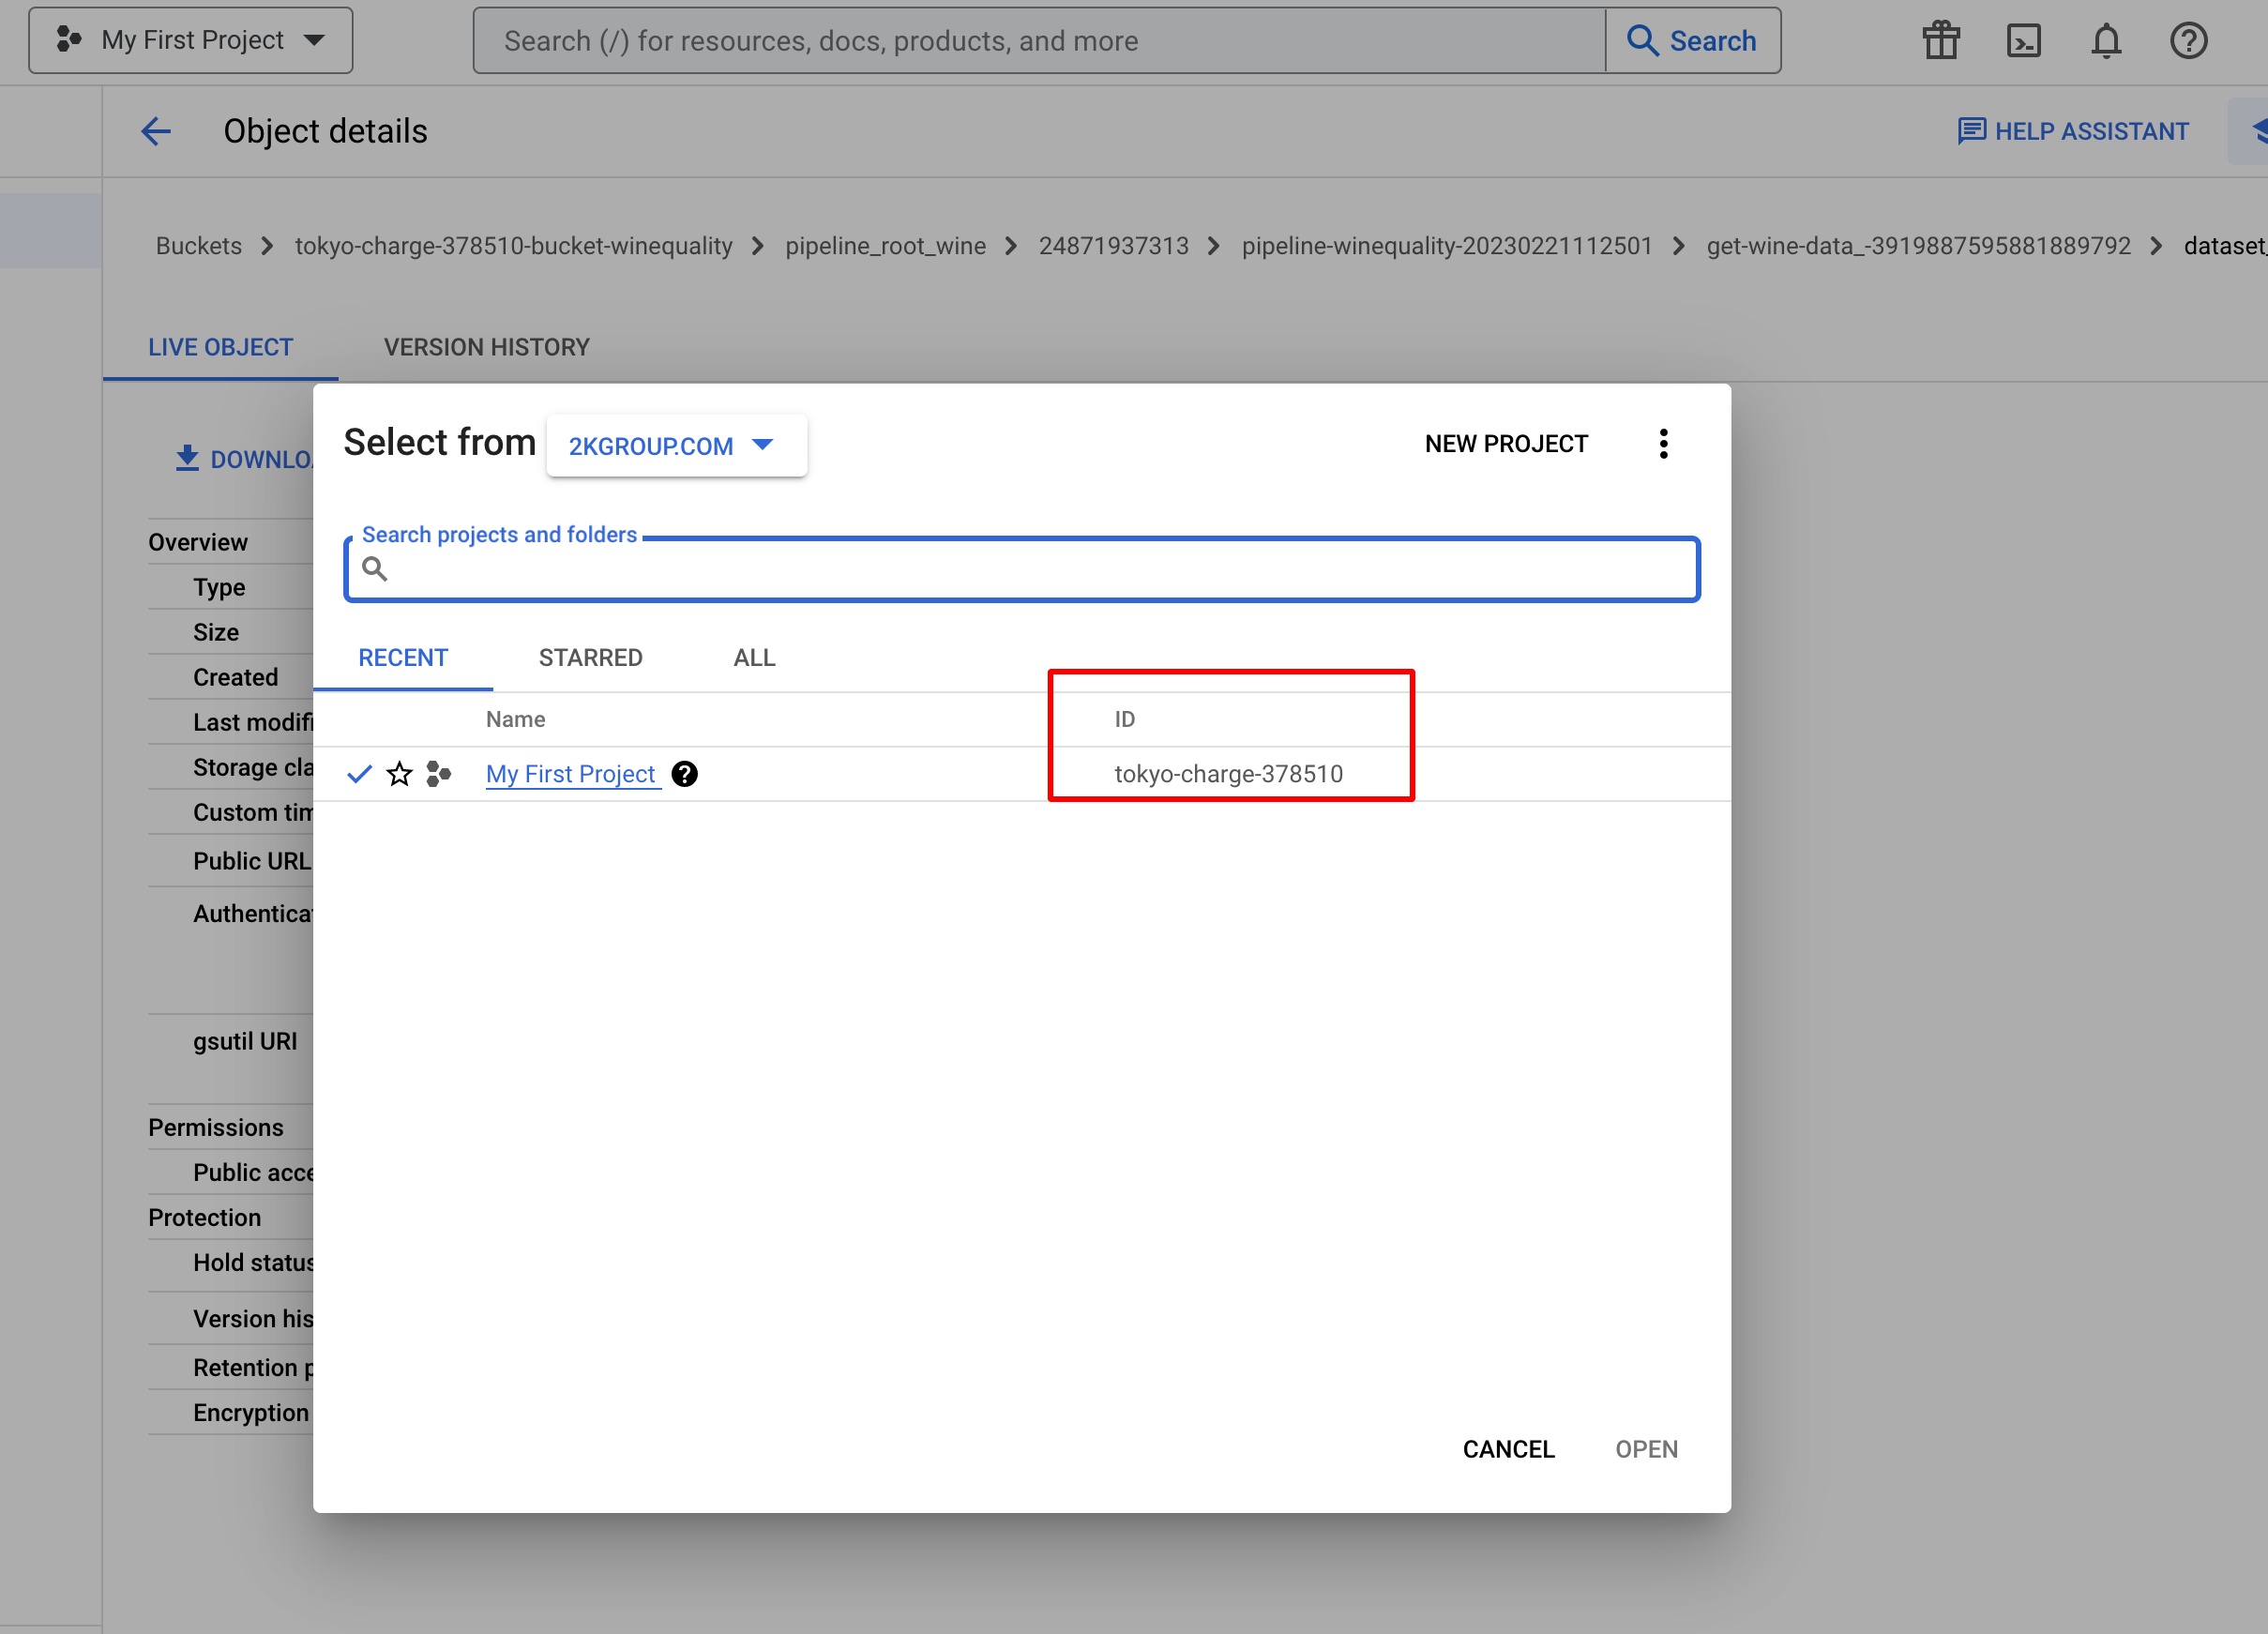

In [2]:
!gcloud config set project tokyo-charge-378510

Updated property [core/project].


Then we need to authenticate to usage of Google cloud.

In [4]:
!gcloud auth login


You are running on a Google Compute Engine virtual machine.
It is recommended that you use service accounts for authentication.

You can run:

  $ gcloud config set account `ACCOUNT`

to switch accounts if necessary.

Your credentials may be visible to others with access to this
virtual machine. Are you sure you want to authenticate with
your personal account?

Do you want to continue (Y/n)?  Y

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=7CIbJTbPewPklaChsEKnX

And we need to enable the following google cloud services. I have them already enabled.

In [4]:
!gcloud services enable compute.googleapis.com         \
                       containerregistry.googleapis.com  \
                       aiplatform.googleapis.com  \
                       cloudbuild.googleapis.com \
                       cloudfunctions.googleapis.com

Operation "operations/acat.p2-24871937313-f6a6c6ca-b690-425a-bd5a-5246bf085c23" finished successfully.


## Packages install

In [5]:
# Install ai platform, kfp and components
!pip3 install google-cloud-aiplatform kfp google_cloud_pipeline_components

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.8/304.8 KB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.6/870.6 KB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.7/235.7 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 

In [ ]:
# Restart the kernel if necessary
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)


#### Set up the global variables 
Thats an important step.
To find your service account got in GCP to IAM and find an account with name "Compute Engine default service account". Also if you are already in IAM, make sure that your user has Vertex AI Administrator Role to review Vertex AI pipelines.

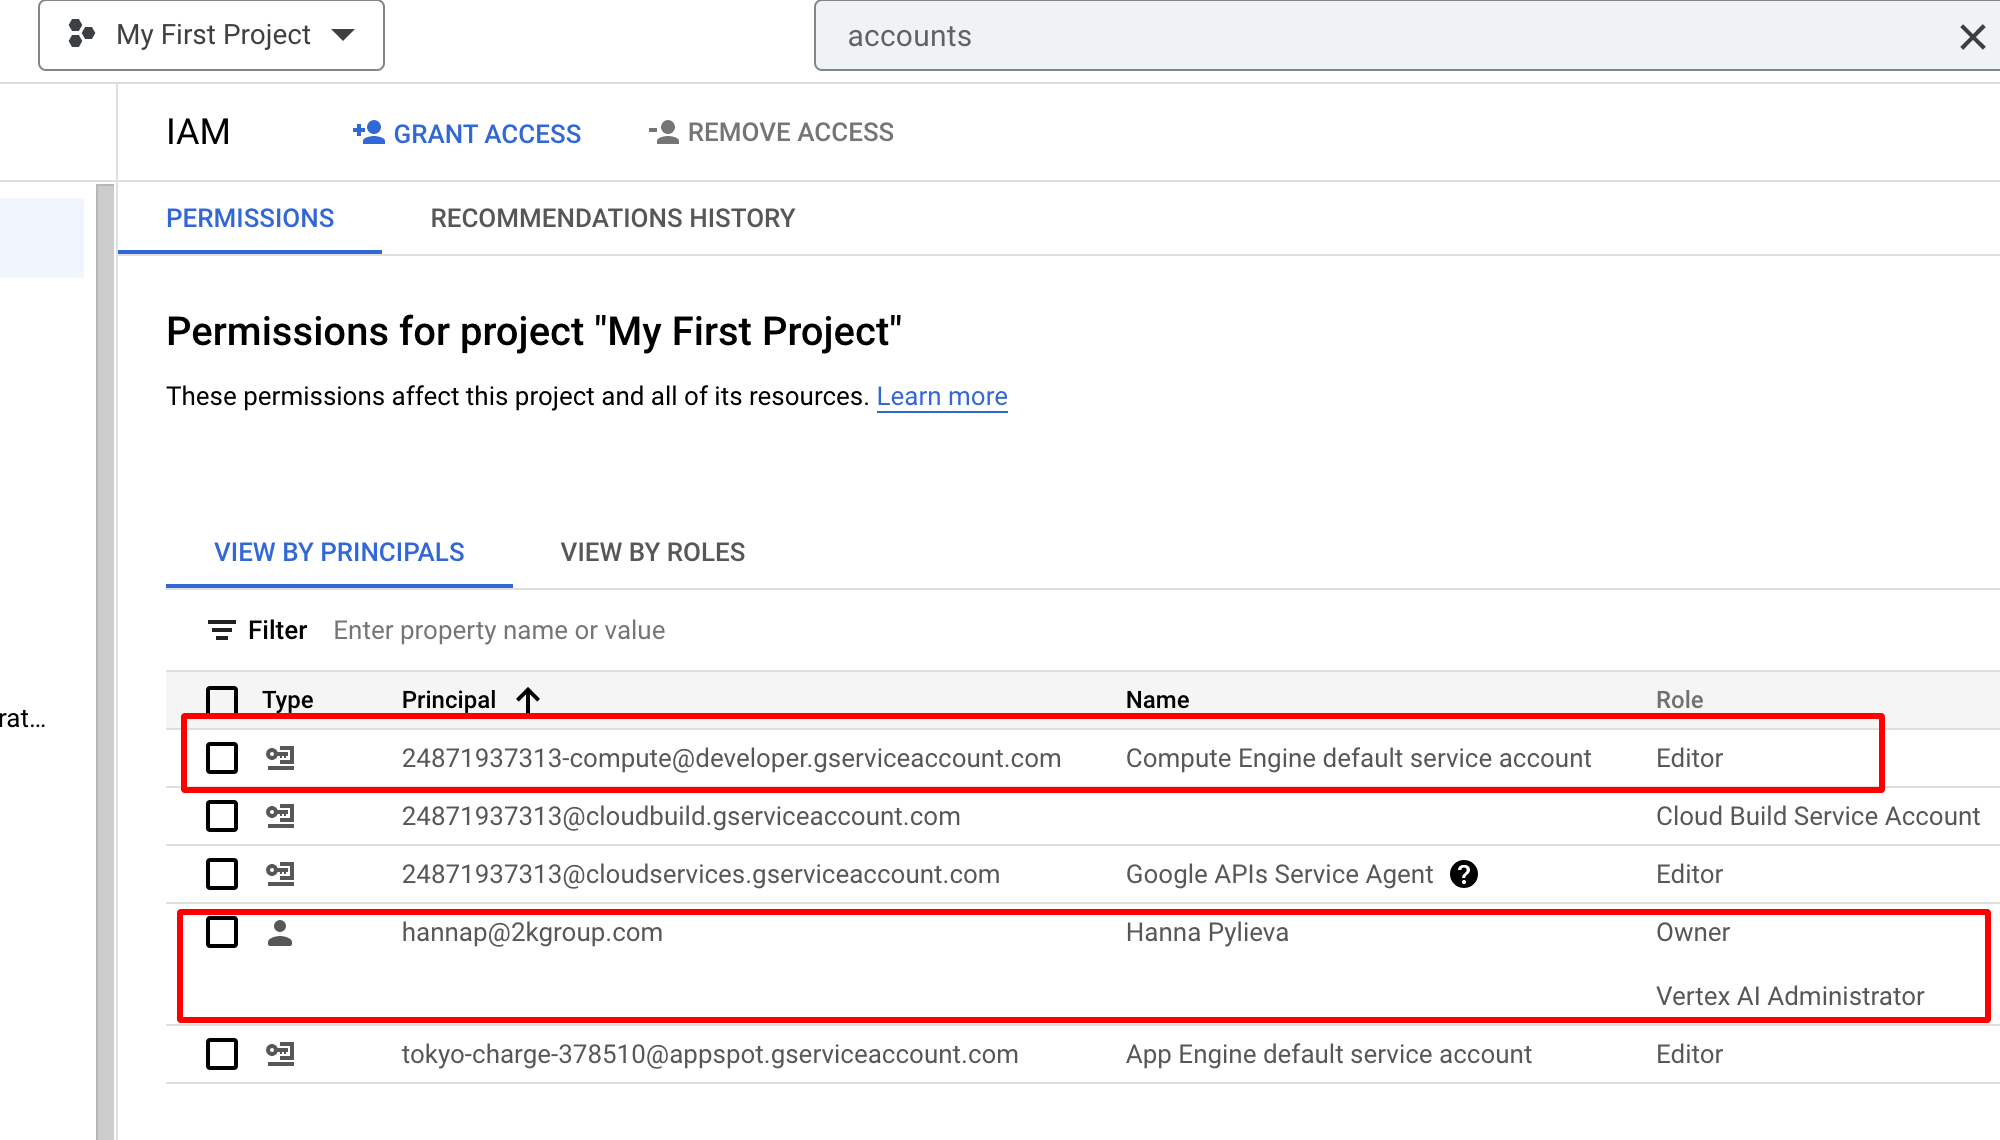

In [1]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin
REGION="europe-west1" # you can specify any other location of your choice

# Get projet name
shell_output=!gcloud config get-value project 2> /dev/null
PROJECT_ID=shell_output[0]

# Set bucket name
BUCKET_NAME="gs://"+PROJECT_ID+"-bucket-winequality"

# Create bucket
PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_root_wine/"
PIPELINE_ROOT

SERVICE_ACCOUNT = "24871937313-compute@developer.gserviceaccount.com"


env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/home/jupyter/.local/bin


### Import all necessary libraries

In [2]:
from typing import NamedTuple
import typing
from kfp.v2 import dsl
from kfp.v2.dsl import (Artifact,
                        Dataset,
                        Input,
                        Model,
                        Output,
                        Metrics,
                        ClassificationMetrics,
                        component, 
                        OutputPath, 
                        InputPath)

from kfp.v2 import compiler
from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud.aiplatform import pipeline_jobs
from google_cloud_pipeline_components import aiplatform as gcc_aip

# Create pipeline

We create 4 components:  
- Load data   
- Train a  model
- Evaluate the model 
- Deploy the model

The components have dependencies on `pandas`, `sklearn`.

Let's look at our data.

In [3]:
import pandas as pd
df_wine = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", delimiter=";")
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
df_wine.quality.describe()

count    4898.000000
mean        5.877909
std         0.885639
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

Available columns: 
- volatile acidity :   Volatile acidity is the gaseous acids present in wine.
- fixed acidity :   Primary fixed acids found in wine are tartaric, succinic, citric, and malic
- residual sugar :   Amount of sugar left after fermentation.
- citric acid :    It is weak organic acid, found in citrus fruits naturally.
- chlorides :   Amount of salt present in wine.
- free sulfur dioxide :   So2 is used for prevention of wine by oxidation and microbial spoilage.
- total sulfur dioxide 
- pH :   In wine pH is used for checking acidity
- density 
- sulphates :    Added sulfites preserve freshness and protect wine from oxidation, and bacteria.
- alcohol :   Percent of alcohol present in wine.



## First component: read the wine quality dataset and store it in Google Cloud Storage
Also let's do some preprocessing as we always do in ML tasks.

In [4]:
@component(
  packages_to_install=["pandas", "pyarrow", "scikit-learn==1.0.0"],
  base_image="python:3.9",
  output_component_file="get_wine_data.yaml"
)
def get_wine_data(
  # An input parameter of type str.
  url: str,
  # Use Output[T] to get a metadata-rich handle to the output artifact of type `Dataset`.
  # the artifact already has path in the place, where we run the pipeline
  dataset_train: Output[Dataset],
  dataset_test: Output[Dataset]
):
  import numpy as np
  import pandas as pd
  from sklearn.model_selection import train_test_split
  
  df_wine = pd.read_csv(url, delimiter=";")
  df_wine['best_quality'] = df_wine.quality.apply(lambda x: int(x>=7)) 
  df_wine['target'] = df_wine.best_quality
  df_wine.drop(
      columns=['quality', 'total sulfur dioxide', 'best_quality'],
      inplace=True
  )
  
  train, test = train_test_split(df_wine, test_size=0.3)
  train.to_csv(dataset_train.path + ".csv" , index=False)
  test.to_csv(dataset_test.path + ".csv" , index=False)

## Train the wine quality model


In [5]:
@component(
  packages_to_install = [
      "pandas",
      "scikit-learn==1.0.0"
  ], base_image="python:3.9",
)
def train_winequality(
  # Use Input[T] to get a metadata-rich handle to the 
  # input artifact of type `Dataset`.
  dataset:  Input[Dataset],
  model: Output[Model], 
):
  import pickle
  import pandas as pd
  from sklearn.ensemble import RandomForestClassifier

  data = pd.read_csv(dataset.path+".csv")
  model_rf = RandomForestClassifier(n_estimators=10)
  model_rf.fit(
      data.drop(columns=["target"]),
      data.target,
  )
  model.metadata["framework"] = "RF"
  file_name = model.path + ".pkl"
  with open(file_name, 'wb') as file:  
      pickle.dump(model_rf, file)

## Evaluate the model 
The results of evaluation will be written in the file in GCP.

In [6]:
@component(
  packages_to_install = [
      "pandas",
      "scikit-learn==1.0.0"
  ], base_image="python:3.9",
)
def winequality_evaluation(
  test_set:  Input[Dataset],
  rf_winequality_model: Input[Model],
  thresholds_dict_str: str,
  metrics: Output[ClassificationMetrics],
  kpi: Output[Metrics]
) -> NamedTuple("output", [("deploy", str)]):

  from sklearn.ensemble import RandomForestClassifier
  import pandas as pd
  import logging 
  import pickle
  from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score
  import json
  import typing

  def threshold_check(val1, val2):
      cond = "false"
      if val1 >= val2 :
          cond = "true"
      return cond

  data = pd.read_csv(test_set.path+".csv")
  file_name = rf_winequality_model.path + ".pkl"
  with open(file_name, 'rb') as file:  
      model = pickle.load(file)
  
  X_test = data.drop(columns=["target"])
  y_target = data.target
  y_pred = model.predict(X_test)

  y_scores =  model.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(
        y_true=data.target.to_numpy(), y_score=y_scores, pos_label=True
  )
  metrics.log_roc_curve(fpr.tolist(), tpr.tolist(), thresholds.tolist())  
  
  metrics.log_confusion_matrix(
      ["False", "True"],
      confusion_matrix(
          data.target, y_pred
      ).tolist(), 
  )
  
  accuracy = accuracy_score(data.target, y_pred.round())
  thresholds_dict = json.loads(thresholds_dict_str)
  rf_winequality_model.metadata["accuracy"] = float(accuracy)
  kpi.log_metric("accuracy", float(accuracy))
  deploy = threshold_check(float(accuracy), int(thresholds_dict['roc']))
  return (deploy,)

## Deploy model 

In [7]:
@component(
  packages_to_install=["google-cloud-aiplatform", "scikit-learn==1.0.0",  "kfp"],
  base_image="python:3.9",
  output_component_file="model_winequality_coponent.yml"
)
def deploy_winequality(
  model: Input[Model],
  project: str,
  region: str,
  serving_container_image_uri : str, 
  vertex_endpoint: Output[Artifact],
  vertex_model: Output[Model]
):
  from google.cloud import aiplatform
  aiplatform.init(project=project, location=region)

  DISPLAY_NAME  = "winequality"
  MODEL_NAME = "winequality-rf"
  ENDPOINT_NAME = "winequality_endpoint"
  
  def create_endpoint():
      endpoints = aiplatform.Endpoint.list(
        filter='display_name="{}"'.format(ENDPOINT_NAME),
        order_by='create_time desc',
        project=project, 
        location=region,
      )
      if len(endpoints) > 0:
          return endpoints[0]  # most recently created
      else:
          return aiplatform.Endpoint.create(
            display_name=ENDPOINT_NAME, project=project, location=region
        )
  endpoint = create_endpoint()
  
  #Import a model programmatically
  model_upload = aiplatform.Model.upload(
      display_name = DISPLAY_NAME, 
      artifact_uri = model.uri.replace("model", ""),
      serving_container_image_uri = serving_container_image_uri,
      serving_container_health_route=f"/v1/models/{MODEL_NAME}",
      serving_container_predict_route=f"/v1/models/{MODEL_NAME}:predict",
      serving_container_environment_variables={
      "MODEL_NAME": MODEL_NAME,
  },       
  )
  model_deploy = model_upload.deploy(
      machine_type="n1-standard-4", 
      endpoint=endpoint,
      traffic_split={"0": 100},
      deployed_model_display_name=DISPLAY_NAME,
  )

  # Save the resource name to the output params
  vertex_model.uri = model_deploy.resource_name

In [10]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
DISPLAY_NAME = 'pipeline-winequality-job{}'.format(TIMESTAMP)

In [10]:
DISPLAY_NAME

'pipeline-winequality-job20230222185710'

## Create the Pipeline itself

Once you have created all the needed components define the pipeline and then compile it into a `.json` file.

In [8]:
PIPELINE_ROOT

'gs://tokyo-charge-378510-bucket-winequality/pipeline_root_wine/'

In [11]:
@dsl.pipeline(
  # Default pipeline root. You can override it when submitting the pipeline.
  pipeline_root=PIPELINE_ROOT,
  # A name for the pipeline. Use to determine the pipeline Context.
  name="pipeline-winequality",
)
def pipeline(
  url: str = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
  project: str = PROJECT_ID,
  region: str = REGION, 
  display_name: str = DISPLAY_NAME,
  api_endpoint: str = REGION+"-aiplatform.googleapis.com",
  thresholds_dict_str: str = '{"roc":0.8}',
  serving_container_image_uri: str = "europe-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest"
):
  data_op = get_wine_data(url)
  train_model_op = train_winequality(data_op.outputs["dataset_train"])
  model_evaluation_op = winequality_evaluation(
      test_set=data_op.outputs["dataset_test"],
      rf_winequality_model=train_model_op.outputs["model"],
      thresholds_dict_str = thresholds_dict_str, # I deploy the model anly if the model performance is above the threshold
  )
  
  with dsl.Condition(
      model_evaluation_op.outputs["deploy"]=="true",
      name="deploy-winequality",
  ):  
      deploy_model_op = deploy_winequality(
        model=train_model_op.outputs['model'],
        project=project,
        region=region, 
        serving_container_image_uri = serving_container_image_uri,
      )
    

### Compile and run the pipeline

In [12]:
compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path='ml_winequality.json'
)

/usr/local/lib/python3.8/dist-packages/kfp/v2/compiler/compiler.py:1290: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  warnings.warn(


The pipeline compilation generates the **ml_winequality.json** job spec file.

In [ ]:
### Create a run 

In [13]:
aiplatform.init(project=PROJECT_ID, location=REGION)

In [ ]:
# might be needed if we restarted the notebook before
# from google.colab import auth
# auth.authenticate_user()

In [14]:
start_pipeline = pipeline_jobs.PipelineJob(
  display_name="winequality-pipeline",
  template_path="ml_winequality.json",
  enable_caching=True,
  location=REGION
)

In [15]:
start_pipeline.run(service_account=SERVICE_ACCOUNT)

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west1/pipelines/runs/pipeline-winequality-20230223131539?project=24871937313


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west1/pipelines/runs/pipeline-winequality-20230223131539?project=24871937313


PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob run completed. Resource name: projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob run completed. Resource name: projects/24871937313/locations/europe-west1/pipelineJobs/pipeline-winequality-20230223131539


### List all models 

In [17]:
DISPLAY_NAME = "winequality"
! gcloud ai models list --region={REGION} --filter={DISPLAY_NAME}

Using endpoint [https://europe-west1-aiplatform.googleapis.com/]
MODEL_ID             DISPLAY_NAME
5324670930528501760  winequality
7072067585948254208  winequality


### Schedule pipeline 

The scheduled jobs are supported by the Cloud Scheduler and Cloud Functions. 
Check that the APIs Cloud Scheduler, Cloud Functions are enabled.

Below is a code to create a scheduled pipeline run

In [31]:
from kfp.v2.google.client import AIPlatformClient

api_client = AIPlatformClient(
                project_id=PROJECT_ID,
                region=REGION,
                )

response = api_client.create_schedule_from_job_spec(
    enable_caching=True,
    job_spec_path="ml_winequality.json",
    schedule="0 0 * * 1", # once per week on Monday
    time_zone="Europe/Brussels",  # change this as necessary
    parameter_values={"display_name": DISPLAY_NAME},
    pipeline_root=PIPELINE_ROOT,  # this argument is necessary if you did not specify PIPELINE_ROOT as part of the pipeline definition.
    #service_account=SERVICE_ACCOUNT,   
)


/usr/local/lib/python3.8/dist-packages/kfp/v2/google/client/client.py:169: FutureWarning: AIPlatformClient will be deprecated in v2.0.0. Please use PipelineJob https://googleapis.dev/python/aiplatform/latest/_modules/google/cloud/aiplatform/pipeline_jobs.html in Vertex SDK. Install the SDK using "pip install google-cloud-aiplatform"
  warnings.warn(


Once the scheduled job is created, you can see it listed in the Cloud Scheduler panel in the Console.

# Get predictions from endpoint

We can check our model performance by calling endpoint. And for sure we can call it for the new data coming.

In [ ]:
! pip install gcsfs

In [19]:
# here is how to read data from GCS. You need to be authorized!

import gcsfs
import pandas as pd

fs = gcsfs.GCSFileSystem()

data_path = 'gs://tokyo-charge-378510-bucket-winequality/pipeline_root_wine/24871937313/pipeline-winequality-20230222190608/get-wine-data_-3056498289194041344/dataset_test.csv'
with fs.open(data_path, 'rb') as f:
    test_df = pd.read_csv(f, nrows=10) # let's read just a chunk of data to speed up data load

In [20]:
# create instances
instances = test_df.drop(columns='target').values.tolist()

In [21]:
instances

[[7.3, 0.28, 0.36, 12.7, 0.04, 38.0, 0.998, 3.3, 0.79, 9.6],
 [8.2, 0.42, 0.29, 4.1, 0.03, 31.0, 0.9911, 3.0, 0.32, 12.8],
 [7.2, 0.17, 0.34, 6.4, 0.042, 16.0, 0.99278, 2.99, 0.4, 10.8],
 [7.0, 0.15, 0.28, 14.7, 0.051, 29.0, 0.99792, 2.96, 0.39, 9.0],
 [7.3, 0.32, 0.35, 1.4, 0.05, 8.0, 0.99244, 3.24, 0.42, 10.7],
 [7.6, 0.19, 0.41, 1.1, 0.04, 38.0, 0.9907, 2.92, 0.42, 11.4],
 [7.0, 0.22, 0.26, 9.2, 0.027, 37.0, 0.99228, 3.06, 0.34, 12.5],
 [6.9, 0.18, 0.36, 1.3, 0.036, 40.0, 0.9934, 3.27, 0.95, 9.5],
 [6.8, 0.19, 0.4, 9.85, 0.055, 41.0, 0.99532, 2.98, 0.56, 10.5],
 [6.6, 0.27, 0.25, 1.2, 0.033, 36.0, 0.98918, 3.16, 0.37, 12.4]]

In [24]:
ENDPOINT_ID = !(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)'\
              --filter=display_name=$ENDPOINT_NAME \
              --sort-by=creationTimeStamp)

In [26]:
ENDPOINT_NAME="winequality_endpoint"

# get the endpoint id
# ENDPOINT_ID = !(gcloud ai endpoints list --region=$REGION \
#               --format='value(ENDPOINT_ID)'\
#               --filter=display_name=$ENDPOINT_NAME \
#               --sort-by=creationTimeStamp)
ENDPOINT_ID = '7273225437273128960' # the most recent endpoint


# aiplatform.init(project=PROJECT_ID, location=REGION)
endpoint = aiplatform.Endpoint(ENDPOINT_ID)
prediction = endpoint.predict(instances=instances)


In [30]:
prediction.predictions

[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]

In [28]:
list(map(int, prediction.predictions)), test_df.target.tolist()

([0, 1, 0, 1, 0, 0, 1, 1, 0, 0], [0, 1, 0, 1, 0, 0, 1, 1, 0, 0])

So the model performance is quite good. At least on those 10 records :)

# Test the batch prediction

Takes some time, but at least you will have a code and understanding of how to run it.



In [ ]:
# Define variables 
job_display_name = "winequality-batch-prediction-job"
MODEL_NAME="winequality"
ENDPOINT_NAME="winequality_endpoint"
BUCKET_URI="gs://tokyo-charge-378510-bucket-winequality/pipeline_root_wine/24871937313/pipeline-winequality-20230222111722/get-wine-data_5671759263626690560"
input_file_name="dataset_test.csv"

# Get model id
MODEL_ID=!(gcloud ai models list --region=$REGION \
           --filter=display_name=$MODEL_NAME)
MODEL_ID=MODEL_ID[2].split(" ")[0]

model_resource_name = f'projects/{PROJECT_ID}/locations/{REGION}/models/{MODEL_ID}'
gcs_source= [f"{BUCKET_URI}/{input_file_name}"]
gcs_destination_prefix=f"{BUCKET_URI}/output"

def batch_prediction_job(
    project: str,
    location: str,
    model_resource_name: str,
    job_display_name: str,
    gcs_source: str,
    gcs_destination_prefix: str,
    machine_type: str,
    starting_replica_count: int = 1, # The number of nodes for this batch prediction job. 
    max_replica_count: int = 1,    
):   
    aiplatform.init(project=project, location=location)

    model = aiplatform.Model(model_resource_name)

    batch_prediction_job = model.batch_predict(
        job_display_name=job_display_name,
        instances_format='csv', #json
        gcs_source=[f"{BUCKET_URI}/{input_file_name}"],
        gcs_destination_prefix=f"{BUCKET_URI}/output",
        machine_type=machine_type, # must be present      
    )
    batch_prediction_job.wait()
    print(batch_prediction_job.display_name)
    print(batch_prediction_job.state)
    return batch_prediction_job

batch_prediction_job(PROJECT_ID, REGION, model_resource_name, job_display_name, gcs_source, gcs_destination_prefix, machine_type="n1-standard-2")

# Clean up!

In [30]:
# setup the following parameters manually

DISPLAY_NAME = "pipeline-winequality-20230222111722"
BUCKET_URI = "gs://tokyo-charge-378510-bucket-winequality/pipeline_root_wine/24871937313/aaa"

In [24]:
import os
delete_pipeline = True
delete_bucket = True

try:
    if delete_pipeline and "DISPLAY_NAME" in globals():
        pipelines = aiplatform.PipelineJob.list(
            filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
        )
        pipeline = pipelines[0]
        aiplatform.PipelineJob.delete(pipeline.resource_name)
        print("Deleted pipeline:", pipeline)
except Exception as e:
    print(e)

if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -r $BUCKET_URI

list index out of range
CommandException: The rm command (without -I) expects at least one URL.


In [31]:
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -r $BUCKET_URI

Removing gs://tokyo-charge-378510-bucket-winequality/pipeline_root_wine/24871937313/aaa/#1677076552959385...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              


Then we need to go the the Vertex AI and delete deployed models.
This is important as everyhting we store on cloud costs something.